# ElasticSearch integrated BERT Model for iKnowledge dataset v1

This notebook will help you search through the articles present in the iKnowledge Management database. The query matching is done with the help of elastic search which evaluates based on the score of cosine similarity.

This is simple version which retrieves articles quickly. This can be fine-tuned for heavier datasets.

Pre-requisities/Lookout(s):


*   Set up the server 3.1.26.243 using AWS before using this notebook.
*   Finish setting up the API as given in the steps and proceed with the bulk indexing.
*   The dataset/json file is to be uploaded from local.

---
---


Done by : Emmanuel Rajapandian

Dated : 23-07-2020

---
---



# Contents

See "Table of contents" in the sidebar to the left.

# 1. Setup

*Follow the procedure in the order of the cells and you will be able to use the ElasticSearch BERT model.*

## 1.1 Installing the HuggingFace Library

Install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2). The model is implemented with PyTorch (at least 1.0.1) using transformers v3.0.2.

Run this command to install the required packages.

In [ ]:
!pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.3.1)


## 1.2 Installing ElasticSearch

Run this command to install the required packages.

In [ ]:
!pip install elasticsearch

# 2. Acquiring the dataset

## 2.1 Required Libraries

Run this cell to import the necessary packages required to implement the model.

In [ ]:
import numpy as np
import json
import pandas as pd
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import xml.etree.ElementTree as ET

Execute the following cell to get all the required packages.

In [ ]:
!pip freeze > requirements.txt

If you want to execute this ElasticSearch in Local, run the following cell to download the `requirements.txt` which contains all the necessary packages.

Download the ElasticSearch, SentenceTransformers and the pre-Trained Model from the following Links:



1.   ElasticSearch - https://www.elastic.co/downloads/elasticsearch
2.   SentenceTransformers - https://github.com/UKPLab/sentence-transformers
3.   Pre-Trained Model - https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/



In [ ]:
from google.colab import files
files.download('requirements.txt')

## 2.2 Downloading Pre-Trained Model

These models were trained on SNLI and MultiNLI dataset to create universal sentence embeddings. Change the model name in the follwing cell to download the appropriate model.


>Name | Details | Benchmark Score
>--- | --- | ---
>bert-base-nli-mean-tokens | BERT-base model with mean-tokens pooling. |77.12
>bert-large-nli-mean-tokens | BERT-large with mean-tokens pooling. | 79.19
>roberta-base-nli-mean-tokens | RoBERTa-base with mean-tokens pooling. | 77.49
>roberta-large-nli-mean-tokens | RoBERTa-base with mean-tokens pooling. | 78.69
>distilbert-base-nli-mean-tokens | DistilBERT-base with mean-tokens | 76.97

In [ ]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

## 2.3 Uploading our dataset

Upload the iknowledge management json file from local in the follwing cell.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving iknow_topic.json to iknow_topic.json


The following cell extracts the titles of the articles. Change the file name at `f = open('iknow_topic.json')`

In [ ]:
import random

count = 0
iknow_dataset = []

f = open('iknow_topic.json')
data = json.load(f)
for i in data:
  count+=1
for i in range(count):
  iknow_dataset.append(data[i].get('Title'))

print("Random Title: ",random.choice(iknow_dataset))

Random Title:  SSRS Reports horinzontal scroll bar not visible in IE 11


At the end of the previous cell, the random function has been called to display an article title randomly.

---

The next set of cells contains details to extract about 300,000 titles of articles/questions present in Academic Stackoverflow.



## 2.4 Random dataset in a zip file

Paste any url of the zip file and then following two cells will download extract the files and place in the colaboratory directory.

In [ ]:
!wget https://archive.org/download/stackexchange/academia.stackexchange.com.7z

--2020-07-23 06:29:38--  https://archive.org/download/stackexchange/academia.stackexchange.com.7z
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia800107.us.archive.org/27/items/stackexchange/academia.stackexchange.com.7z [following]
--2020-07-23 06:29:38--  https://ia800107.us.archive.org/27/items/stackexchange/academia.stackexchange.com.7z
Resolving ia800107.us.archive.org (ia800107.us.archive.org)... 207.241.232.17
Connecting to ia800107.us.archive.org (ia800107.us.archive.org)|207.241.232.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124338591 (119M) [application/x-7z-compressed]
Saving to: ‘academia.stackexchange.com.7z’

academia.stackexcha 100%[===================>] 118.58M  1.20MB/s    in 45s     

2020-07-23 06:30:24 (2.65 MB/s) - ‘academia.stackexchange.com.7z’ saved [124338591/124338591]



In [ ]:
!apt-get install p7zip-full

!p7zip -d academia.stackexchange.com.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 124338591 bytes (119 MiB)

Extracting archive: academia.stackexchange.com.7z
--
Path = academia.stackexchange.com.7z
Type = 7z
Physical Size = 124338591
Headers Size = 343
Method = BZip2
Solid = +
Blocks = 7

  0%      2% - Badges.xml                   3% 1 - Comments.xml                       5% 1 -

In [ ]:
# This cell is when the questions are present in XML Format. Change the file name accordingly.

import xml.dom.minidom
tree = xml.dom.minidom.parse('PostHistory.xml')

In [ ]:
import random

stackoverflow_dataset = []
count = 0
ex = tree.getElementsByTagName("row") # Here 'row' is the name of all the rows present in the XML file.
for skill in ex:
  count+=1
  stackoverflow_dataset.append(skill.getAttribute("Text")) # We are extracting the titles which are present in the "Text" attribute.
                                                           # Change the attribute name according to your file.

print("The number of titles present in the given dataset: ",count)
print("\nRandom Question: ",random.choice(stackoverflow_dataset))

The number of titles present in the given dataset:  294243

Random Question:  Is simplified writing/accessible tone frowned upon in publications?


# 3. Index creation

Use the online API tester at https://apitester.com/ to add a new index to an Elasticsearch cluster.

Steps to follow to add a new index using the API Tester:


1.   Select 'PUT' method and enter the IP address followed by the index name.
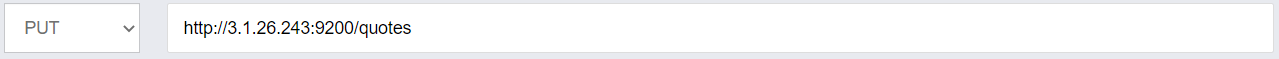
2.   In the 'Post Data', add the following text to create a new index.
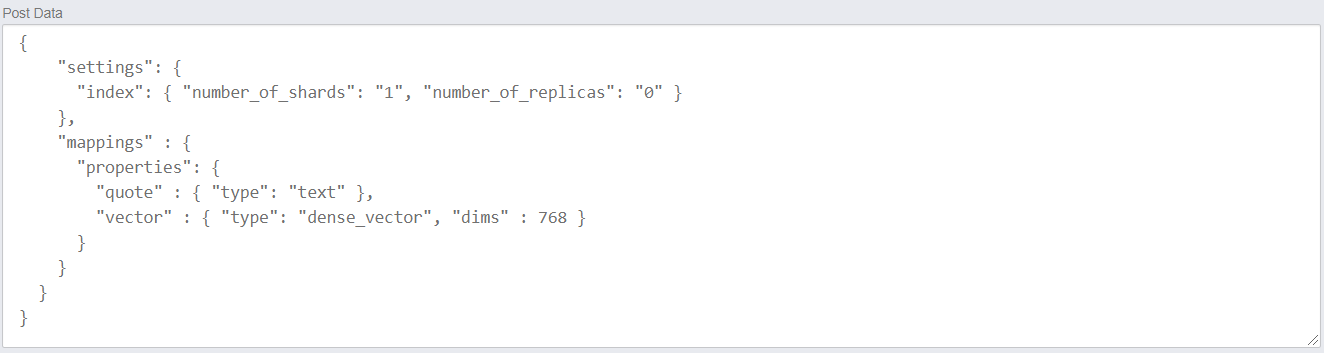
3.   Click on Add Request header and type the following.
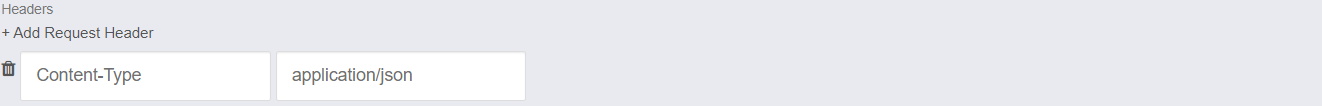
4. Click on the test button and you will receive a success message. Test the same IP address in a new tab and you should receive the following message:

`{"quotes":{"aliases":{},"mappings":{"properties":{"quote":{"type":"text"},"vector":{"type":"dense_vector","dims":768}}},"settings":{"index":{"creation_date":"1595315948869","number_of_shards":"1","number_of_replicas":"0","uuid":"FR44TBdjToG9xf54RpFqwQ","version":{"created":"7080099"},"provided_name":"quotes"}}}}`


The quotes/titles of the abstract are read from a file. Then the dense vector is computed by calling sentence-encoder, and indexed into Elasticsearch in bulk.


## 3.1 Indexing and Embedding

Here the dataset is feed as input to the process of index creation. Along with the title, its embedded values are calculated through a function and then indexed with the title.

In [ ]:
es = Elasticsearch([{'host':'3.1.26.243','port':9200}])
def getQuotes():
  for line in stackoverflow_dataset[0:200]: # Change to 'stackoverflow_dataset' if you want to search through the Academia Staackexchange.
        quote = line
        yield {
            "_index": 'quotes', # Here 'quotes' is the index name. This is the name that is appended at the end of the IP address.
            "quote" : quote,
            "vector" : embedder.encode(quote)[0].tolist()
              }

# bulk is used here to append multiple documents.
bulk(client=es, actions = getQuotes(), chunk_size=300000, request_timeout = 120)

(200, [])

For any dataset, the output would be the number of titles followed by a` [ ]` bracket.

Eg : `(x,[ ])`

# 4.  ElasticSearch

The following cell calculates the scores between the query and the titles/quotes indexed in bulk. It then displays the top 10 BERT results and the top ten MLT results.



1.   BERT - Bidirectional Encoder representational Transformer
2.   MLT - More Like This








## 4.1 Relevancy Scoring and Entering the query

The `inQuiry` takes the query typed by the user and returns back similiar queries calculated by the said two methods.

In [ ]:
client = Elasticsearch([{'host':'3.1.26.243','port':9200}])

def findRelevantHits (inQuiry):
    inQuiry_vector = embedder.encode([inQuiry])[0].tolist()
    queries = {
        'bert': {
           "script_score": {
              "query": {
                 "match_all": {}
               },
               "script": {
                  "source": "cosineSimilarity(params.inQuiry_vector, doc['vector']) + 1.0",
                  "params": {
                     "inQuiry_vector": inQuiry_vector
                   }
                }
           }
        },
        'mlt': {
                "more_like_this": {
                        "fields": ["quote"],
                        "like": inQuiry,
                        "min_term_freq": 1,
                        "max_query_terms": 50,
                        "min_doc_freq": 1
                }
        }
    }

    result = {'bert' : [], 'mlt' : [] }

    for metric, query in queries.items():
        body = { "query": query, "size" : 5, "_source" : ["quote"] }
        response = client.search(index='quotes',body=body, request_timeout=120)
        result[metric] = [a['_source']['quote'] for a in response['hits']['hits']]
    return result


# Enter your Query in the next line and the ElasticSearch will retrieve top 10 titles.
inQuiry = "BBC Japan Broadcasting"
result = findRelevantHits (inQuiry)

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


# 5. Results


## 5.1 Result Count

The following cell displays how many queries are retrieved using the BERT and MLT standards.

In [ ]:
count = len(result['bert'])
mltcount = len(result['mlt'])
print(count)
print(mltcount)

5
5


## 5.2 The relevant queries

This cell displays all the top 5 queries matched and displayed in the descending order of cosine similarity score.

In [ ]:
print("The relevant documents to the query are: \n")

for i in range(count):
  print(result['bert'][i])

print("\nMore queries like this: \n")

for i in range(mltcount):
  print(result['mlt'][i])

The relevant documents to the query are: 

When did BBC Japan begin broadcasting?
What is the Japan Broadcasting Corporation called?
When did comic supplements start showing up in Japan?
What is the acronym for British Broadcasting Corporation?
What program with a direction in its name does the BBC broadcast from Southampton?

More queries like this: 

When did BBC Japan begin broadcasting?
What is the Japan Broadcasting Corporation called?
For how long did the BBC alternate different broadcasting systems?
Where did the BBC continue broadcasting from in October of 1936?
How many different areas does BBC One accommodate with customized broadcasting?


Thus, the relevant titles are extracted by ElasticSearch in a very marginal time.

## 5.3 Side-by-Side Comparision

According to research and famous blogs, MLT retrieves better results when the query has lesser words or words which are in Vocabulary.

BERT is always better as it deals with Out of Vocabulary (OOV) Words.

In [ ]:
for k , v in result.items(): # iterating freqa dictionary
        print(k+"\t", v)

bert	 ['When did BBC Japan begin broadcasting?', 'What is the Japan Broadcasting Corporation called?', 'When did comic supplements start showing up in Japan?', 'What is the acronym for British Broadcasting Corporation?', 'What program with a direction in its name does the BBC broadcast from Southampton?']
mlt	 ['When did BBC Japan begin broadcasting?', 'What is the Japan Broadcasting Corporation called?', 'For how long did the BBC alternate different broadcasting systems?', 'Where did the BBC continue broadcasting from in October of 1936?', 'How many different areas does BBC One accommodate with customized broadcasting?']


# 6. Conclusion

This model has a performance mark of about 85%. In the future, this can be integrated into a search interface.